## Dataset

In [1]:
import os
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm_notebook
import warnings
import IPython.display as ipd
import museval
import mir_eval.separation as eval3

warnings.simplefilter(action='ignore', category=Warning)

model_path = 'FullSpectrogram_model'
model_name = 'model_6_f12'

musdb_train_path = 'data/musdb18/preprocessed/train/'
musdb_valid_path = 'data/musdb18/preprocessed/valid/'
musdb_test_path = 'data/musdb18/preprocessed/test/'

dsd_train_path = 'data/DSD100/preprocessed/train/'
dsd_test_path = 'data/DSD100/preprocessed/test/'

dsd_eval_path = 'EvalData/DSD100'
musdb_eval_path = 'EvalData/MUSDB2018'

mix_name = 'linear_mixture'
target_name = 'voc'

dim_c = 4
dim_f = 2**12
dim_t = 2**5
n_fft=2*(dim_f-1)
hop_factor = 2
hop_length=n_fft//hop_factor
sampling_rate = 44100
sampling_size = hop_length * (dim_t+hop_factor-1)
trim = 15000  # trim each generated sub-signal (noise due to conv zero-padding)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



def to_specs(signal):
    specs = []
    for channel in signal:
        spectrogram = librosa.stft(channel, n_fft=n_fft, center=False, hop_length=hop_length)
        specs.append(spectrogram.real)
        specs.append(spectrogram.imag)
    return np.array(specs)

def restore(specs):
    ri = np.reshape(specs, (-1, 2, dim_f, dim_t))
    channels = []
    for ri_c in ri:
        ft_c = ri_c[0] + 1.j * ri_c[1]
        channels.append(librosa.istft(ft_c, center=False, hop_length=hop_length))
    return np.array(channels)


class BssDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.mix_path = file_path + mix_name
        self.target_path = file_path + target_name

    def __len__(self):
        return len([name for name in os.listdir(self.mix_path)])

    def __getitem__(self, index):
        mix_track = np.load('{0}/{1}.npy'.format(self.mix_path, index))
        target_track = np.load('{0}/{1}.npy'.format(self.target_path, index))

        s = np.random.randint(mix_track.shape[1] - sampling_size)
        mix = to_specs(mix_track[:, s:s+sampling_size])
        target = to_specs(target_track[:, s:s+sampling_size])

        return torch.tensor(mix), torch.tensor(target) 



print(sampling_size)
b = BssDataset(dsd_train_path)
b[0][0].shape

135135


torch.Size([4, 4096, 32])

## Modeling

In [2]:
class Self_Att(nn.Module):
    def __init__(self, c, f, t, h, d_k, d_v) :
        super(Self_Att, self).__init__()
        self.c, self.f, self.t = c, f, t
        self.h, self.d_k, self.d_v = h, d_k, d_v
        self.scale = math.sqrt(d_k)
        self.dropout = nn.Dropout(p=0.1)

        self.to_query = nn.Linear(t, d_k*h)
        self.to_key = nn.Linear(t, d_k*h)
        self.to_value = nn.Linear(t, d_v*h)
        self.to_output = nn.Linear(d_v*h, t)
        self.att = None
    
    def get_qkv (self, x):
        q = self.to_query(x).view(-1, self.c, self.f, self.h, self.d_k).transpose(-2,-3)
        k = self.to_key(x).view(-1, self.c, self.f, self.h, self.d_k).transpose(-2,-3)
        v = self.to_value(x).view(-1, self.c, self.f, self.h, self.d_v).transpose(-2,-3)
        return q, k, v
                 
    def forward (self, x):
        
        Q, K, V = self.get_qkv(x)  # [B, C, h, F, d_k], [B, C, h, F, d_k], [B, C, h, F, d_v]
        
        scores = torch.matmul(Q, K.transpose(-1,-2))/self.scale
                         
        attention = func.softmax(scores, dim=-1)  # [B, C, h, F, F]
        self.att = attention
        
        attV = torch.matmul(self.dropout(attention), V)  # [B, C, h, F, d_v]
        
        O = self.to_output(attV.transpose(-2,-3).contiguous().view(-1, self.c, self.f, self.d_v*self.h))
        
        return O   # [B, C, F, T]
    
    
class Self_Att_Block(nn.Module):
    def __init__(self, c, f, t, num_layers, num_heads, d_k, d_v) :
        super(Self_Att_Block, self).__init__()
        self.L = num_layers
        self.pos = nn.Parameter(torch.ones(f, t))
        self.att_layers = nn.ModuleList()
        for i in range(num_layers):
             self.att_layers.append(
                nn.Sequential(
                    nn.BatchNorm2d(c),
                    nn.ReLU(),
                    Self_Att(dim_c, dim_f, dim_t, num_heads, d_k, d_v)
                )
            )
            
    def forward (self, x):
        x = x + self.pos
        for i in range(self.L):
            x = x + self.att_layers[i](x)
       
        return x

    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2    

In [10]:
class DenseNet(nn.Module):
    def __init__(self, in_c, l, k, fx, fy, pos_size=None):
        super(DenseNet, self).__init__()
        c = in_c
        self.H = nn.ModuleList()
        
        for i in range(l):
            self.H.append(
                nn.Sequential(
                    nn.BatchNorm2d(c),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=c, out_channels=k, 
                                            kernel_size=(fx, fy), stride=1, padding=(fx//2, fy//2))
                )
            )
            c += k
            
        
        self.pos_f1 = None if pos_size is None else nn.Parameter(torch.ones(pos_size))
        self.pos_f2 = None if pos_size is None else nn.Parameter(torch.zeros(pos_size))
        
    def forward(self, x):
        if self.pos_f1 is not None:
            x = self.pos_f1.unsqueeze(1) * x + self.pos_f2.unsqueeze(1)
        x_ = self.H[0](x)
        for h in self.H[1:]:
            x = torch.cat((x_, x), 1)
            x_ = h(x)    
            
        return x_
        
    
class MDenseNet(nn.Module):
    def __init__(self, L, l, k, fx, fy, t_scale):
        super(MDenseNet, self).__init__()
        self.n = L//2
        self.mid_dim = (dim_f//2**self.n, dim_t//2**len(t_scale))
        
        self.ds_dense = nn.ModuleList()
        self.ds = nn.ModuleList()
        for i in range(self.n):
            self.ds_dense.append(DenseNet(dim_c if i==0 else k, l, k, fx, fy, pos_size=dim_f//2**i))
            
            scale = (2,2) if i in t_scale else (2,1)
            self.ds.append(
                nn.Sequential(
                    nn.BatchNorm2d(k),
                    nn.Conv2d(in_channels=k, out_channels=k, kernel_size=1, stride=1),
                    nn.AvgPool2d(kernel_size=scale, stride=scale)
                )
            )
        
        
        self.mid_dense = DenseNet(k, l, k, fx, fy, pos_size=dim_f//2**self.n)
        #self.att = Self_Att_Block(k, self.mid_dim[0], self.mid_dim[1], num_layers=2, num_heads=2, d_k=128, d_v=32)
        
        
        self.us_dense = nn.ModuleList()
        self.us = nn.ModuleList()
        for i in range(self.n):
            self.us_dense.append(DenseNet(2*k, l, k, fx, fy, pos_size=dim_f//2**(self.n-1 - i)))
            
            scale = (2,2) if i in self.n-1 - t_scale else (2,1)
            self.us.append(
                nn.Sequential(
                    nn.BatchNorm2d(k),
                    nn.ConvTranspose2d(in_channels=k, out_channels=k, kernel_size=scale, stride=scale),
                )
            )
        
        self.pos_f1 = nn.Parameter(torch.ones(dim_f))
        self.pos_f2 = nn.Parameter(torch.zeros(dim_f))
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm2d(k),
            nn.ReLU(),
            nn.Conv2d(in_channels=k, out_channels=dim_c, kernel_size=1, stride=1)
        )
        
        
    def forward(self, x):
        
        ds_outputs = []
        for i in range(self.n):
            x = self.ds_dense[i](x)
            ds_outputs.append(x)
            x = self.ds[i](x)
        
        x = self.mid_dense(x)
        #x = self.att(x)
        
        for i in range(self.n):
            x = self.us[i](x)
            x = torch.cat((x, ds_outputs[-i-1]), 1)
            x = self.us_dense[i](x)
        
        x = self.pos_f1.unsqueeze(1) * x + self.pos_f2.unsqueeze(1)
        return self.final_conv(x)
    
    
class hp:
    num_layers = 21
    num_d_layers = 1
    growth_rate = 28
    filter_size_x = 3
    filter_size_y = 3
    t_scale = np.array([1,4,7])

## Training 

In [11]:
model = MDenseNet(hp.num_layers, hp.num_d_layers, hp.growth_rate, hp.filter_size_x, hp.filter_size_y, hp.t_scale).to(device)

train_set = BssDataset(file_path=dsd_train_path)
train_iter = DataLoader(train_set, batch_size=4, shuffle=True)
valid_set = BssDataset(file_path=musdb_test_path)
valid_iter = DataLoader(train_set, batch_size=4, shuffle=True)

loss_trace = []
loss_trace_v = []

def init_weights(model, ckpt, epoch=0):
    if ckpt==0:
        for p in model.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)
    else:
        if epoch==0:
            model.load_state_dict(torch.load('{0}/{1}/{2}.pt'.format(model_path, model_name, target_name)))
        else:
            model.load_state_dict(torch.load('{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, epoch)))

In [12]:
criterion = nn.MSELoss()
optim = torch.optim.RMSprop(model.parameters(), lr=1e-3)

#warmup_epochs = 100
lr_decay = 0.9997
lr_func = lambda e: lr_decay**e 
scheduler = torch.optim.lr_scheduler.LambdaLR(optim, lr_lambda=lr_func)

sum(p.numel() for p in model.parameters() if p.requires_grad)  

1218751

In [6]:
init_weights(model, 0)

num_epochs = 10000

start_e = len(loss_trace)
for e in range(start_e, num_epochs):
    model.train()
    loss_sum = 0
    for mix, tar in tqdm_notebook(train_iter):
        mix = mix.to(device)
        tar = tar.to(device)
        y_hat = model(mix)
        loss = criterion(y_hat, tar)
        loss.backward()
        optim.step()
        optim.zero_grad()
        loss_sum += loss.item() * mix.shape[0]
        
    scheduler.step()
    
    ipd.clear_output(wait=True)
    print('epoch' , e)

    epoch_avg_loss = loss_sum / len(train_set)
    loss_trace.append(epoch_avg_loss)
    print(epoch_avg_loss)
    plt.plot(loss_trace)
    plt.ylim(0, 2.0)
    plt.show()
    
    torch.save(model.state_dict(), '{0}/{1}/{2}.pt'.format(model_path, model_name, target_name))
    if e>=4000 and e%500==0:
        torch.save(model.state_dict(), '{0}/{1}/{2}{3:05}.pt'.format(model_path, model_name, target_name, e))
    

KeyboardInterrupt: 

### Generate vocals for all test tracks

In [5]:
# stereo version, shape=(num_intervals, 2, f, t)
def preprocess_track(track_path, s, d):
    y, sr = librosa.load(track_path, mono=False, sr=None, offset=s, duration=d)
    n_sample = y.shape[1]
    
    gen_size = sampling_size-2*trim
    pad = gen_size - n_sample%gen_size
    y_p = np.concatenate((np.zeros((2,trim)), y, np.zeros((2,pad)), np.zeros((2,trim))), 1)
    
    all_specs = []
    i = 0
    while i < n_sample + pad:
        specs = to_specs(y_p[:, i:i+sampling_size])
        all_specs.append(specs)
        i += gen_size

    return torch.tensor(all_specs), sr, pad


def separate(model, mix_path, s=0.0, d=None):
    mix_specs, mix_sr, pad_len = preprocess_track(mix_path, s, d)
   
    # create batches
    batch_size = 4
    i = 0
    num_intervals = mix_specs.shape[0]
    batches = []
    while i < num_intervals:
        batches.append(mix_specs[i:i+batch_size])
        i = i + batch_size

    # obtain estimated target spectrograms
    tar_specs = None
    for batch in tqdm_notebook(batches):
        t_specs = model(batch.to(device))

        if tar_specs is None:
            tar_specs = t_specs.detach().cpu()
        else:
            tar_specs = torch.cat((tar_specs, t_specs.detach().cpu()), 0)

    # reconstruct vocal signal
    tar_specs = tar_specs.numpy()
    tar_signal = np.array([[],[]])
    for i in range(len(tar_specs)):
        tar_signal = np.concatenate((tar_signal, np.array(restore(tar_specs[i]))[:, trim:-trim]), 1)

    tar_signal = tar_signal[:, :-pad_len]
    
    return tar_signal

In [ ]:
for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    m_path = '{0}/test_mix/{1}.wav'.format(dsd_eval_path, track_name)
    t_path = '{0}/{1}/estimates_voc-acc/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)

    tar_signal = separate(model, m_path)
    
    librosa.output.write_wav(t_path, np.array(tar_signal, np.float32), sampling_rate)

## Evaluation

In [8]:
def mean_nan(a):
    return a[~np.isnan(a)].mean()


def dsd_sdr(ref, est, framewise=True):
    if framewise:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images_framewise(ref, est)
    else:
        sdr, isr, sir, sar, perm = eval3.bss_eval_images(ref, est)
    return mean_nan(sdr[0])

def musdb_sdr(ref, est, sr):
    sdr, isr, sir, sar, perm = eval4.metrics.bss_eval(ref, est, window=sr, hop=sr)
    return mean_nan(sdr[0])

### Voc

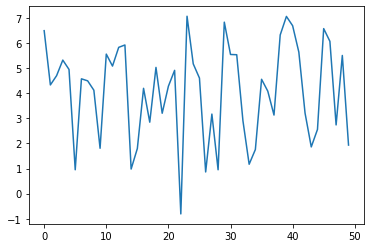

Global values..

SDR mean: 4.0757461657455645
SDR median: 4.518865275698904


In [9]:
import math
import statistics as stats

SDR = []
for i in range(50):
    track_name = 'test_{0:02}'.format(i)
    
    ref, sr = librosa.load('{0}/test_sources/{1}/{2}.wav'.format(dsd_eval_path, track_name, target_name), mono=False, sr=None)

    est_path = '{0}/{1}/mwf_voc-acc/{2}/'.format(model_path, model_name, track_name)
    est, sr = librosa.load(est_path+'voc.wav', mono=False, sr=None)
    
#     mix_path = '{0}/test_mix/{1}.wav'.format(dsd_eval_path, track_name)
#     mix, sr = librosa.load(mix_path, sr=None)
#     est = separate(model, mix_path)
    
    sdr = dsd_sdr(np.array([ref.T]), np.array([est.T]))
    
    print(sdr)
    SDR.append(sdr)
    
    ipd.clear_output(wait=True)
    plt.plot(SDR)
    plt.show()

    print('Global values..\n')
    print('SDR mean:', stats.mean(SDR))
    print('SDR median:', stats.median(SDR))


## Evaluate sub-track

In [6]:
track_name = 'test_{0:02}'.format(0)
s = 0
d = None

ref, sr = librosa.load('{0}/test_sources/{1}/{2}.wav'.format(dsd_eval_path, track_name, target_name), mono=False, sr=None, offset=s, duration=d)

est_path = '{0}/{1}/estimates_sources/{2}/{3}.wav'.format(model_path, model_name, track_name, target_name)
#est, sr = librosa.load(est_path, mono=False, sr=None, offset=s, duration=d)

init_weights(model, 1)
est = separate(model, '{0}/test_mix/{1}.wav'.format(dsd_eval_path, track_name), s=s, d=d)

# ipd.Audio(ref, rate=sr)


In [10]:
ref_ = np.array([ref.T])
est_ = np.array([est.T])

sdr = dsd_sdr(ref_, est_, framewise=True)

print(sdr)

6.695154508636091


### Create estimates folders

In [ ]:
os.mkdir('{0}/{1}/estimates_sources'.format(model_path, model_name))
for i in tqdm_notebook(range(50)):
    track_name = 'test_{0:02}'.format(i)
    p = '{0}/{1}/estimates_sources/test_{2:02}'.format(model_path, model_name, i)
    os.mkdir(p)